In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./data/train.csv")

In [3]:
data.head(100)

,Unnamed: 0,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,FDU04,NaN,Low Fat,0.009715,Frozen Foods,120.0414,OUT019,1985,Small,Tier 1,Grocery Store,487.3656
96,96,FDF41,12.15,Low Fat,0.131384,Frozen Foods,246.0460,OUT049,1999,Medium,Tier 1,Supermarket Type1,1231.7300
97,97,FDB56,8.75,Regular,0.074613,Fruits and Vegetables,187.4556,OUT035,2004,Small,Tier 2,Supermarket Type1,3755.1120
98,98,NCP18,NaN,Low Fat,0.028460,Household,149.9708,OUT027,1985,Medium,Tier 3,Supermarket Type3,4363.6532


In [4]:
data.shape

(14204, 13)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 14204 non-null  int64  
 1   Item_Identifier            14204 non-null  object 
 2   Item_Weight                11765 non-null  float64
 3   Item_Fat_Content           14204 non-null  object 
 4   Item_Visibility            14204 non-null  float64
 5   Item_Type                  14204 non-null  object 
 6   Item_MRP                   14204 non-null  float64
 7   Outlet_Identifier          14204 non-null  object 
 8   Outlet_Establishment_Year  14204 non-null  int64  
 9   Outlet_Size                10188 non-null  object 
 10  Outlet_Location_Type       14204 non-null  object 
 11  Outlet_Type                14204 non-null  object 
 12  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usag

In [6]:
data.drop("Unnamed: 0",axis=1,inplace=True)

In [7]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

<Axes: xlabel='Count', ylabel='Item_Type'>

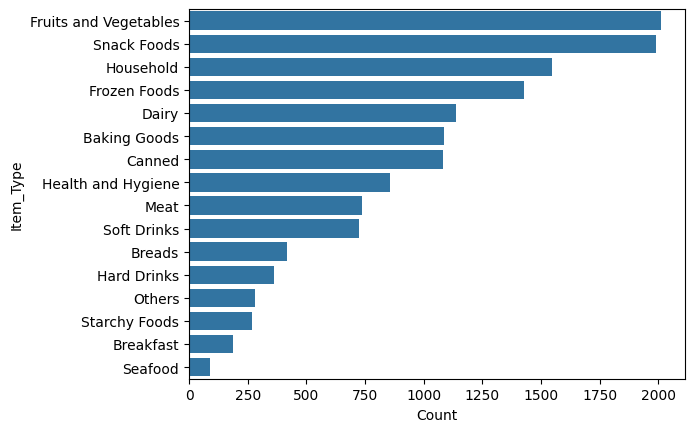

In [9]:
item_type_counts = data["Item_Type"].value_counts(sort=True, ascending=False)

sns.barplot(
    data=pd.DataFrame(
        {"Item_Type": item_type_counts.index, "Count": item_type_counts.values}
    ),
    x="Count",
    y="Item_Type",
)

In [10]:
for i in data.columns:
    print(f"Describing {i}", end="\n")
    print(data[i].describe(), end="\n\n\n")

Describing Item_Identifier
count     14204
unique     1559
top       FDU15
freq         10
Name: Item_Identifier, dtype: object


Describing Item_Weight
count    11765.000000
mean        12.792854
std          4.652502
min          4.555000
25%          8.710000
50%         12.600000
75%         16.750000
max         21.350000
Name: Item_Weight, dtype: float64


Describing Item_Fat_Content
count       14204
unique          5
top       Low Fat
freq         8485
Name: Item_Fat_Content, dtype: object


Describing Item_Visibility
count    14204.000000
mean         0.065953
std          0.051459
min          0.000000
25%          0.027036
50%          0.054021
75%          0.094037
max          0.328391
Name: Item_Visibility, dtype: float64


Describing Item_Type
count                     14204
unique                       16
top       Fruits and Vegetables
freq                       2013
Name: Item_Type, dtype: object


Describing Item_MRP
count    14204.000000
mean       141.004977
std   

In [11]:
print(data["Item_Fat_Content"].unique())
data.loc[
    data["Item_Fat_Content"].isin(["lf", "low fat", "LF"]), "Item_Fat_Content"
] = "Low Fat"

data.loc[data["Item_Fat_Content"].isin(["reg"]), "Item_Fat_Content"] = "Regular"
data["Item_Fat_Content"].unique()

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


array(['Low Fat', 'Regular'], dtype=object)

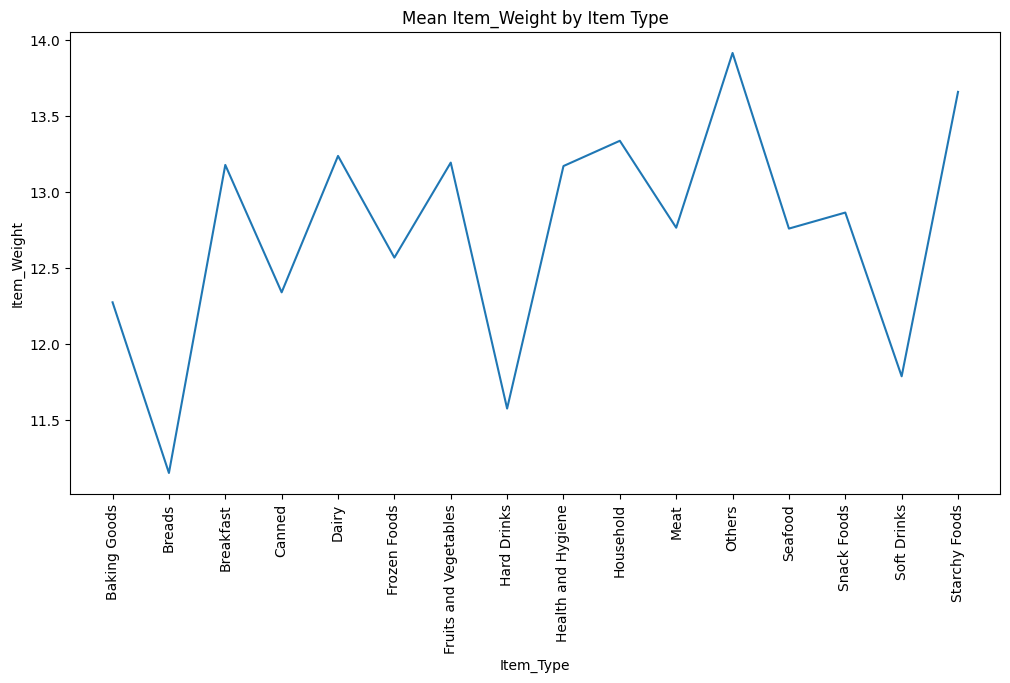

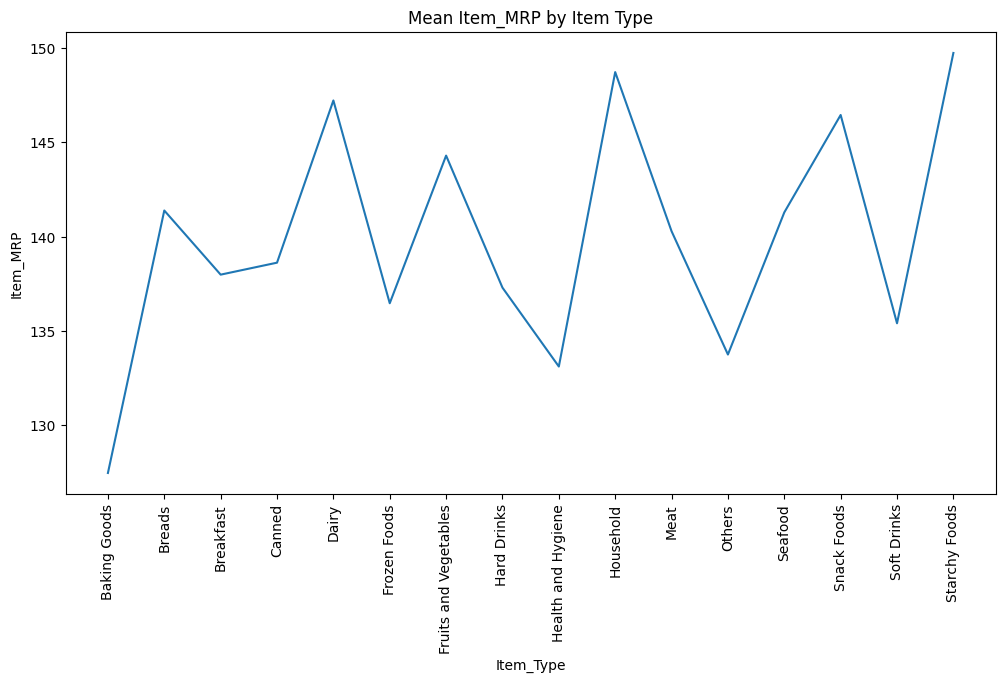

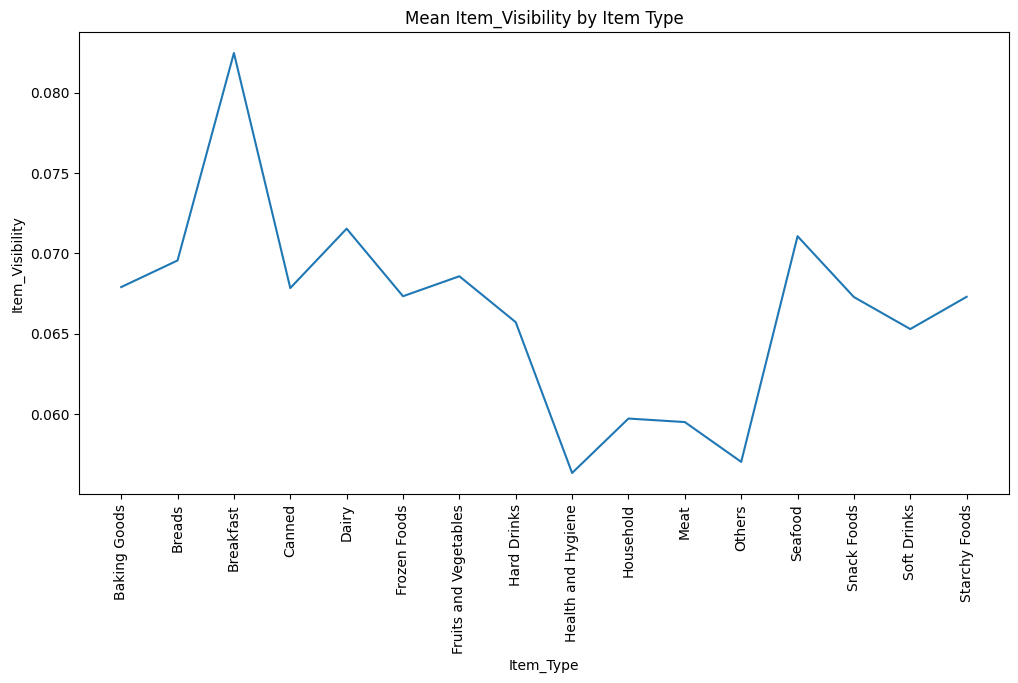

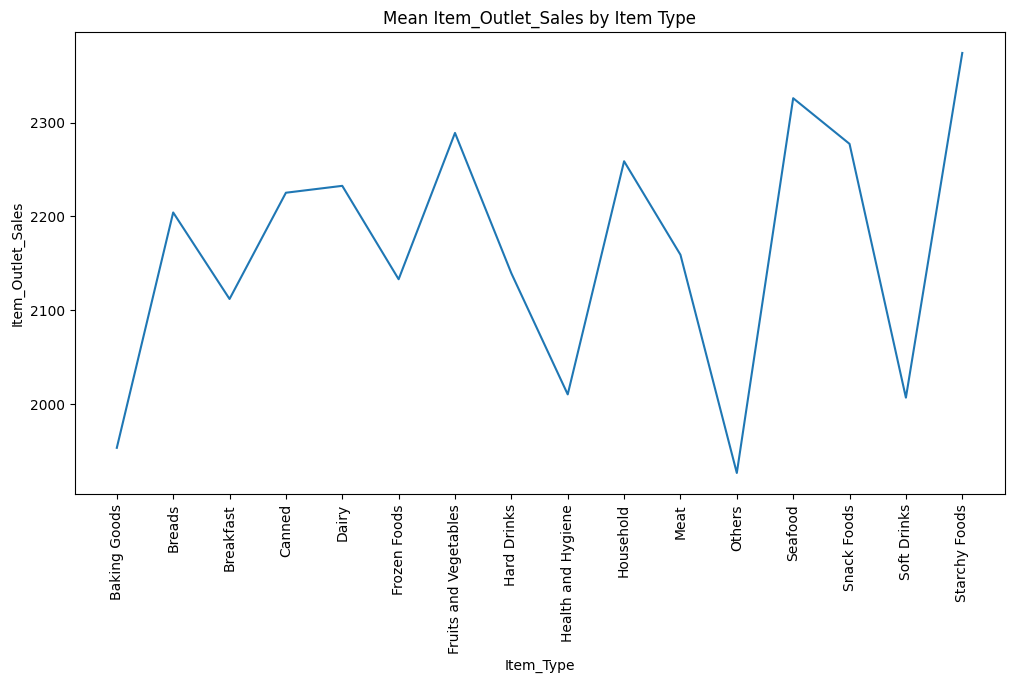

In [12]:
for i in ["Item_Weight","Item_MRP","Item_Visibility","Item_Outlet_Sales"]:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="Item_Type", y=i, data=data[["Item_Type",i]].groupby(["Item_Type"]).mean())
    plt.xticks(rotation=90)
    plt.title(f'Mean {i} by Item Type')
    plt.show()


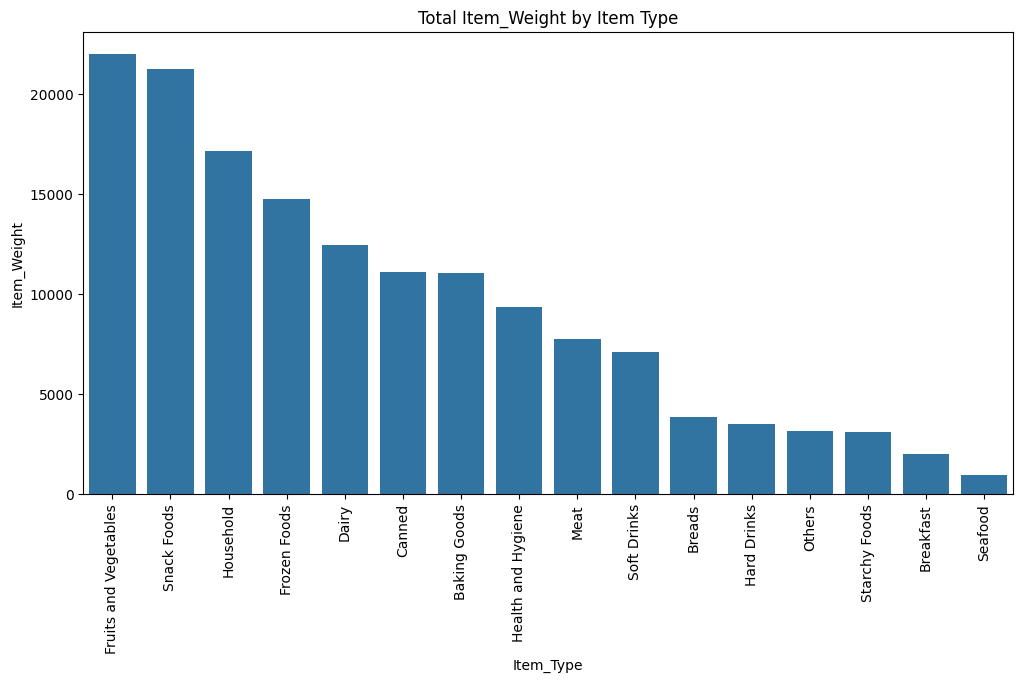

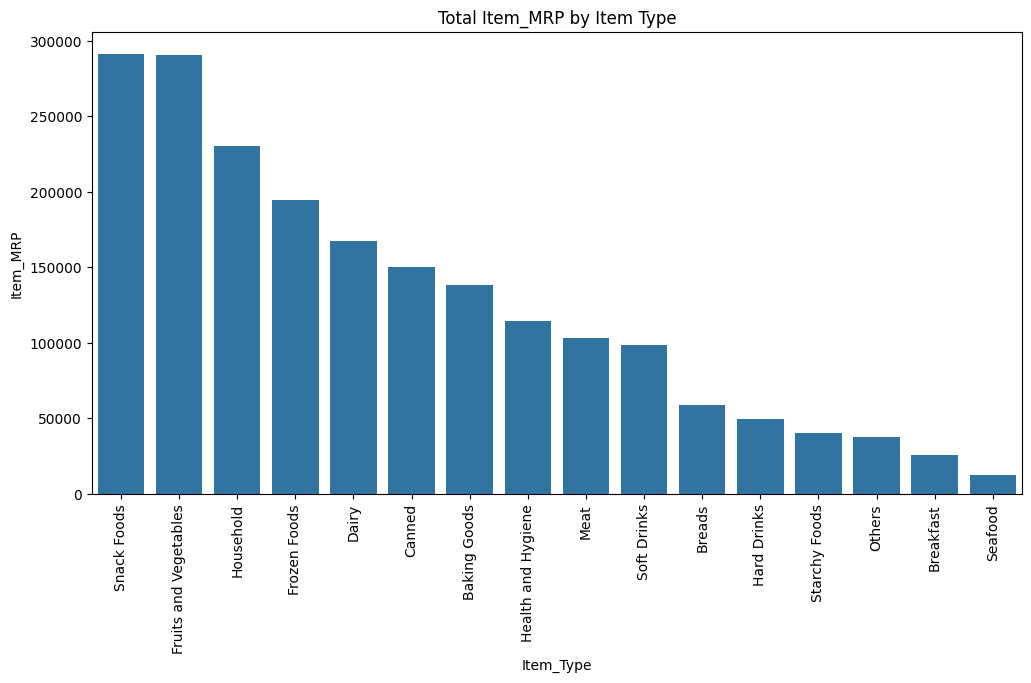

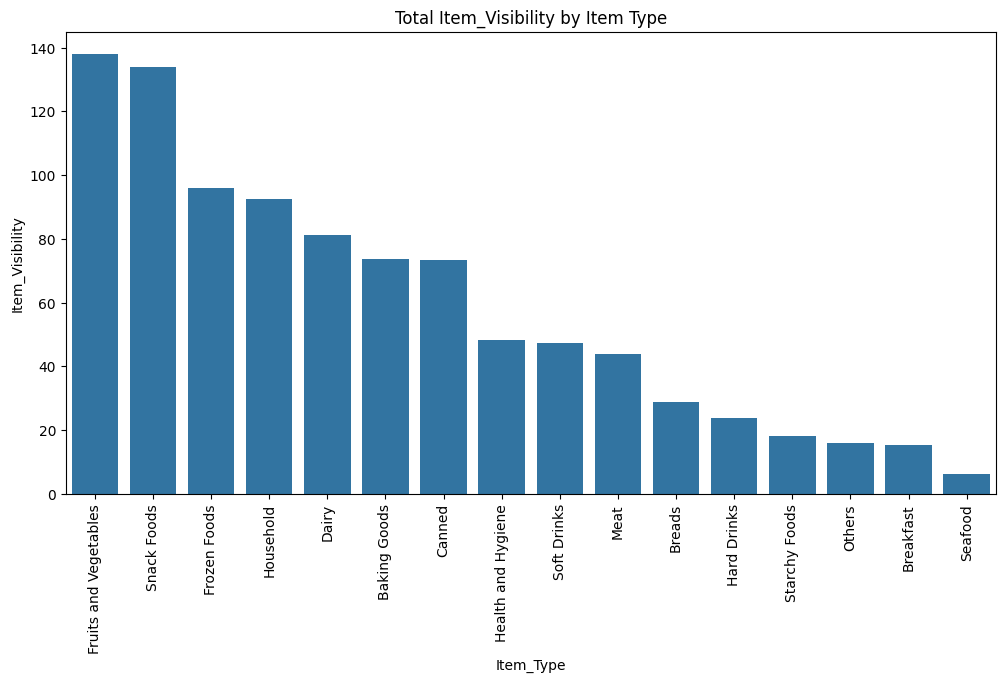

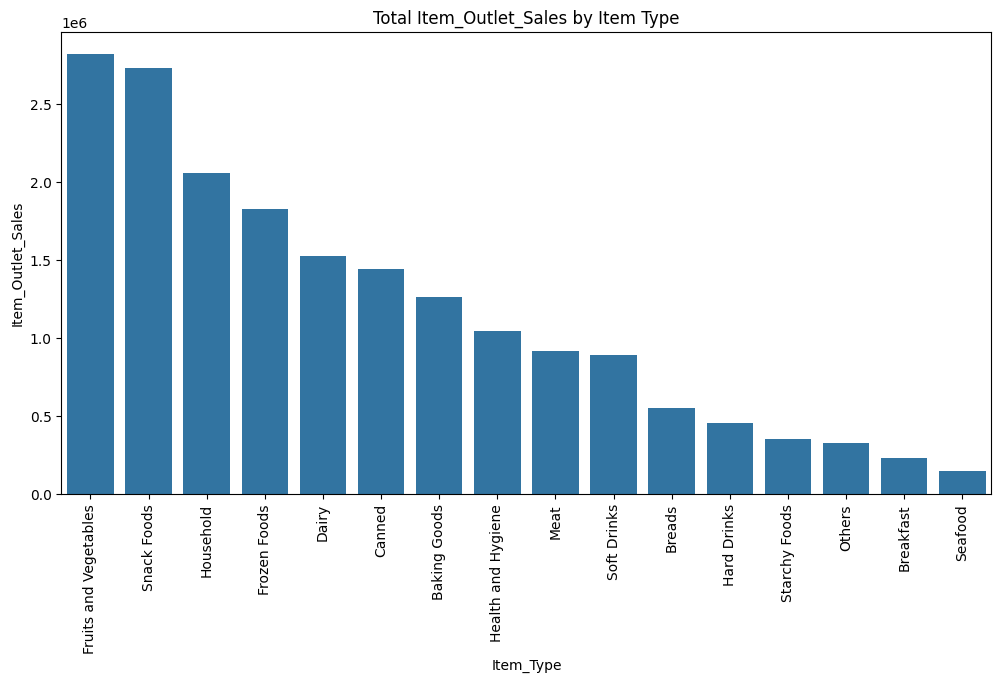

In [13]:
for i in ["Item_Weight","Item_MRP","Item_Visibility","Item_Outlet_Sales"]:
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Item_Type", y=i, data=data[["Item_Type",i]].groupby(["Item_Type"]).sum().sort_values([i],ascending=False
                                                                                                        ))
    plt.xticks(rotation=90)
    plt.title(f'Total {i} by Item Type')
    plt.show()


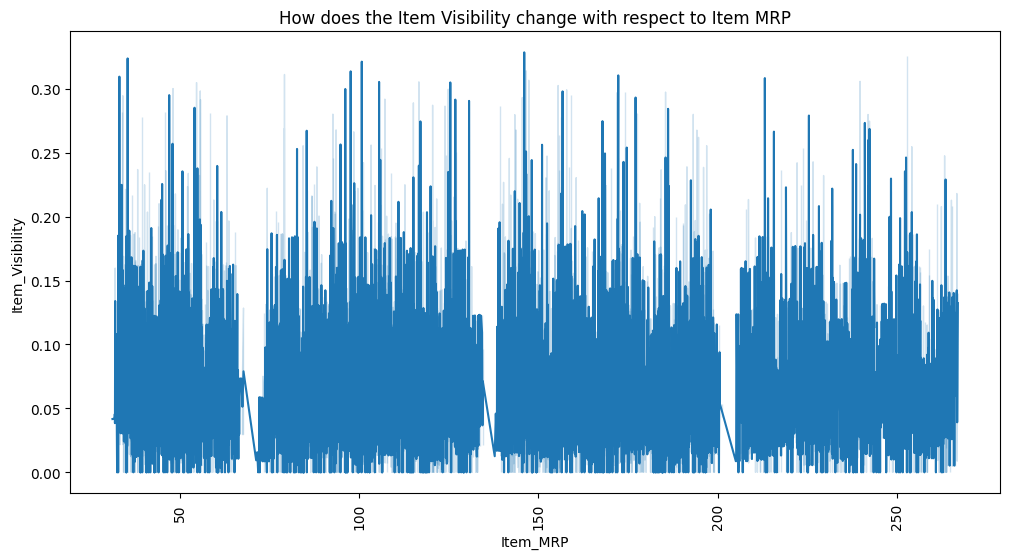

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(y="Item_Visibility", x="Item_MRP", data=data)
plt.xticks(rotation=90)
plt.title(f'How does the Item Visibility change with respect to Item MRP')
plt.show()


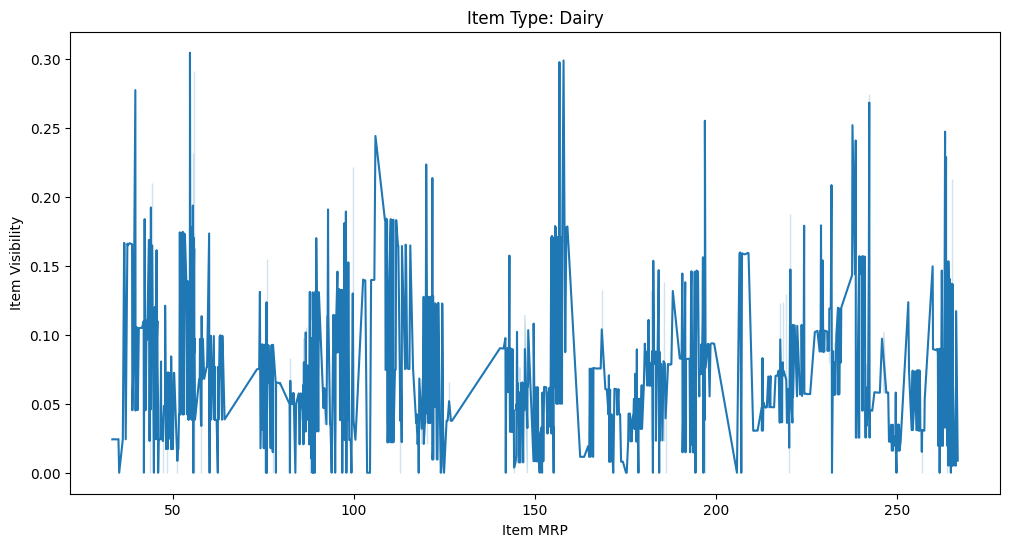

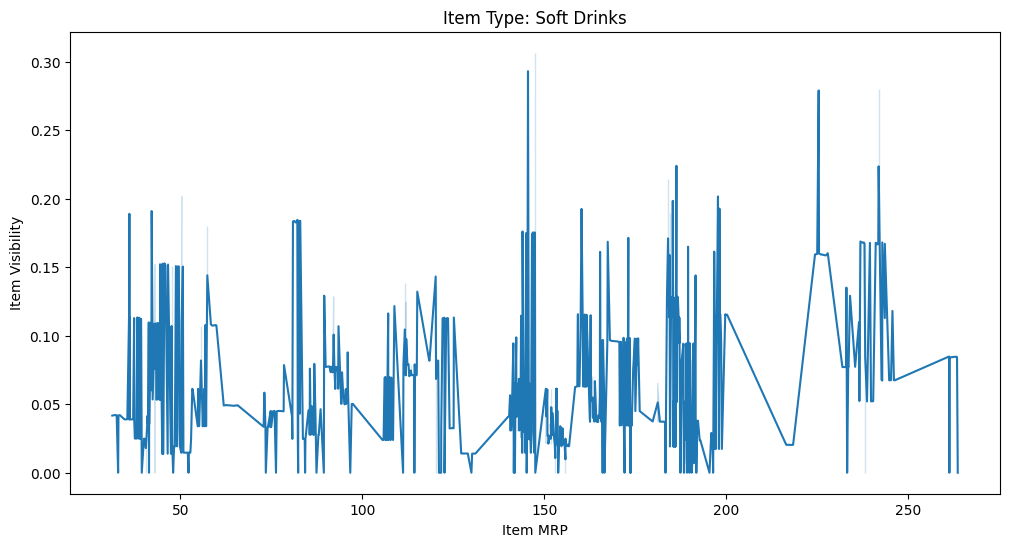

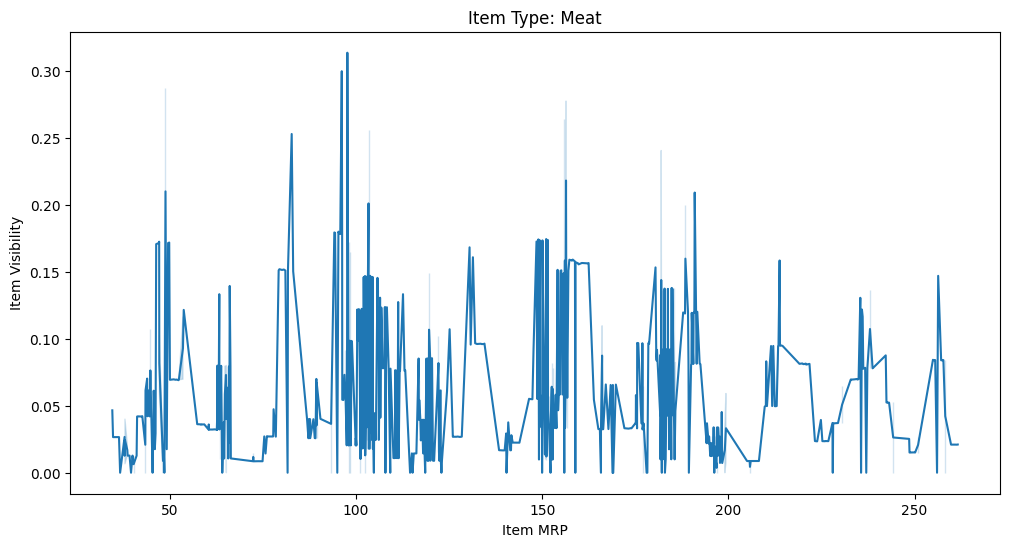

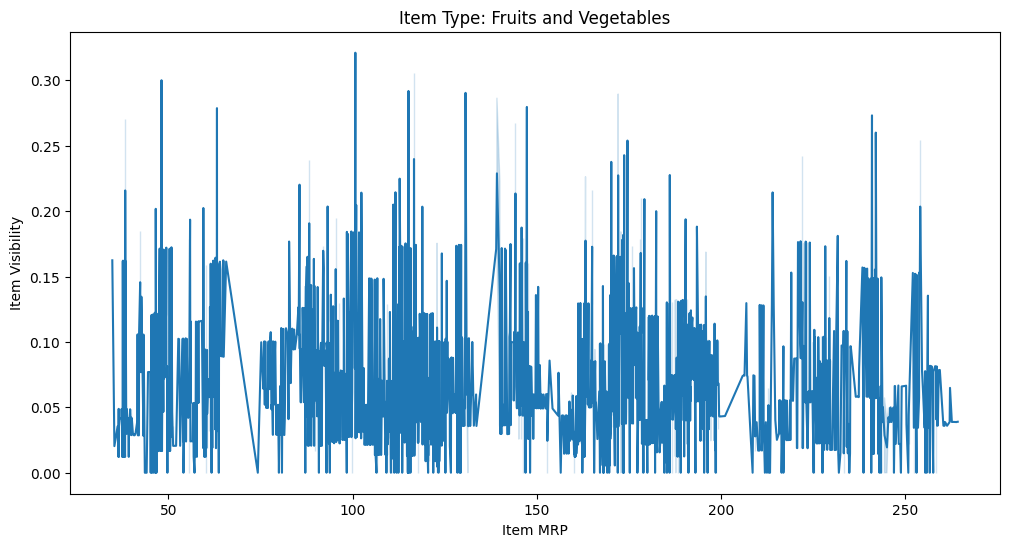

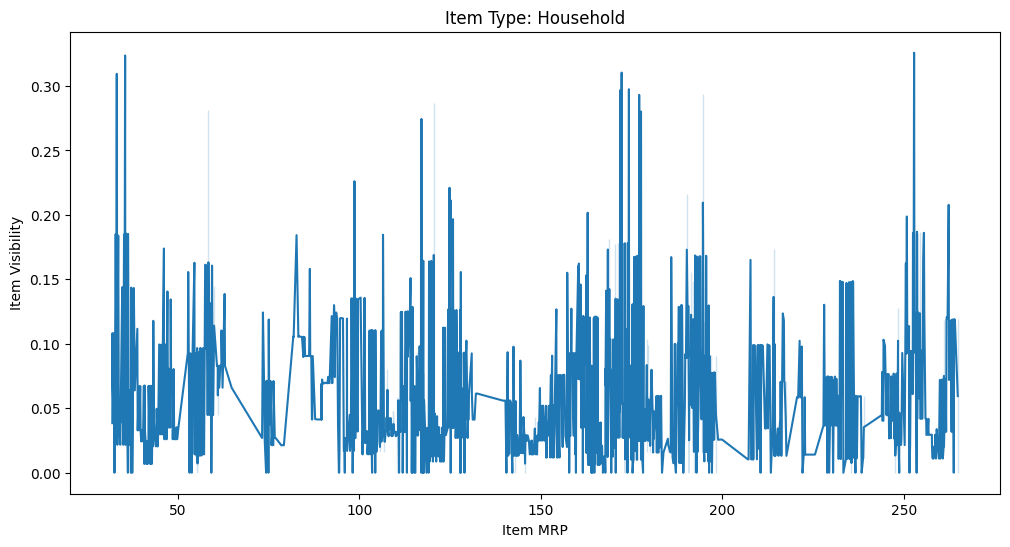

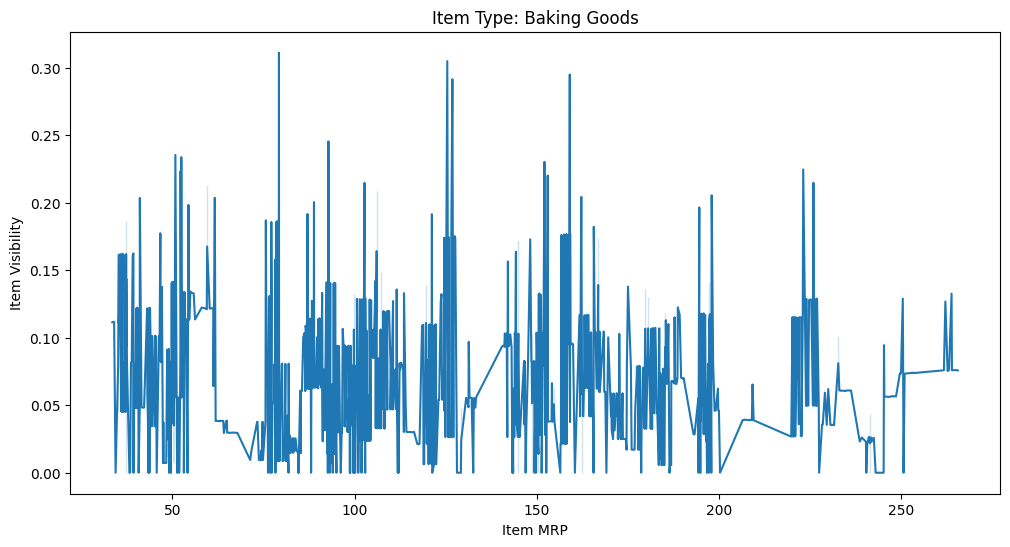

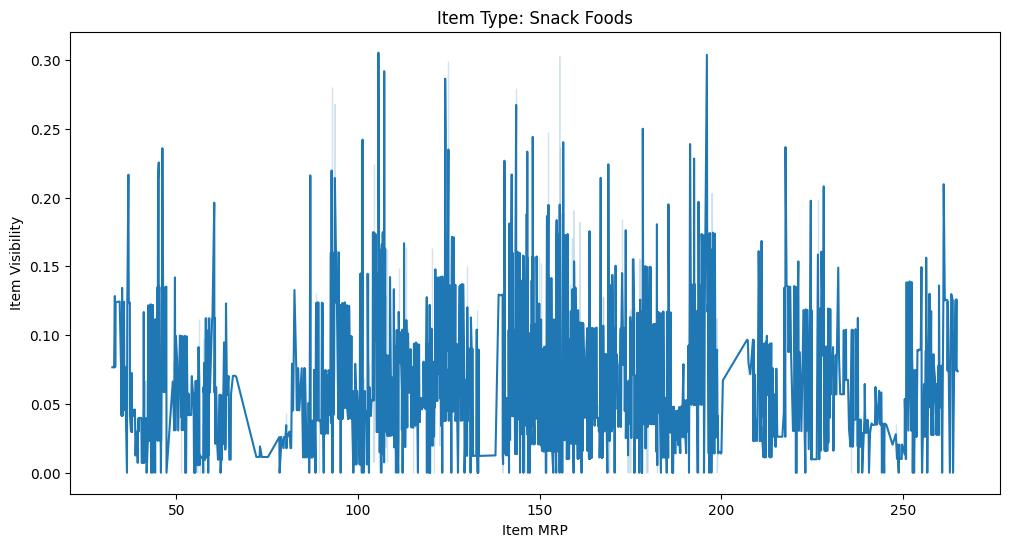

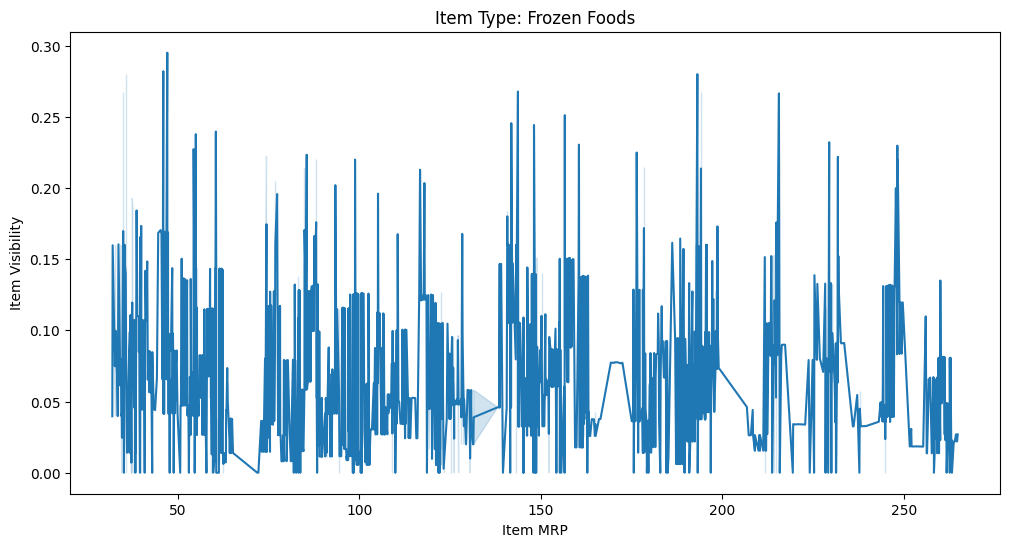

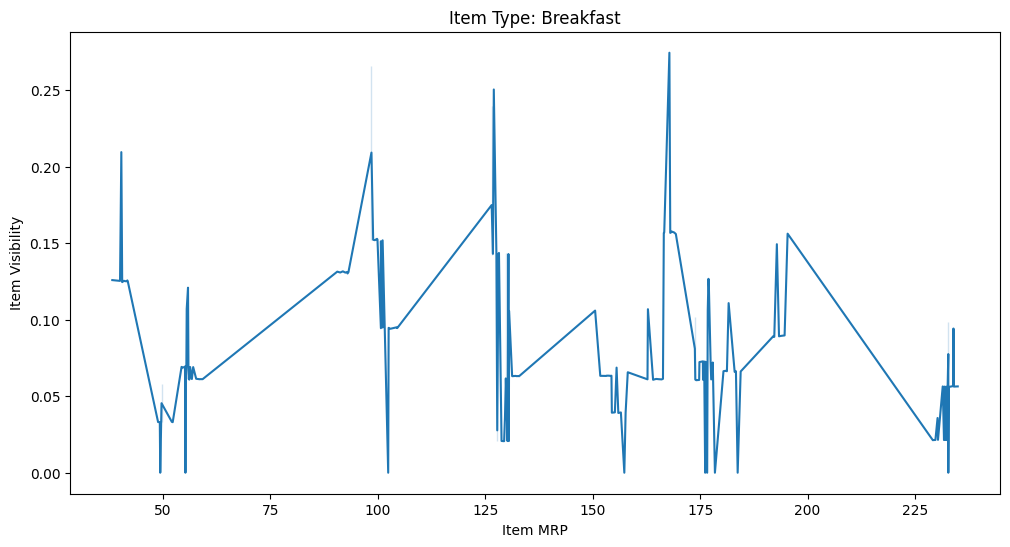

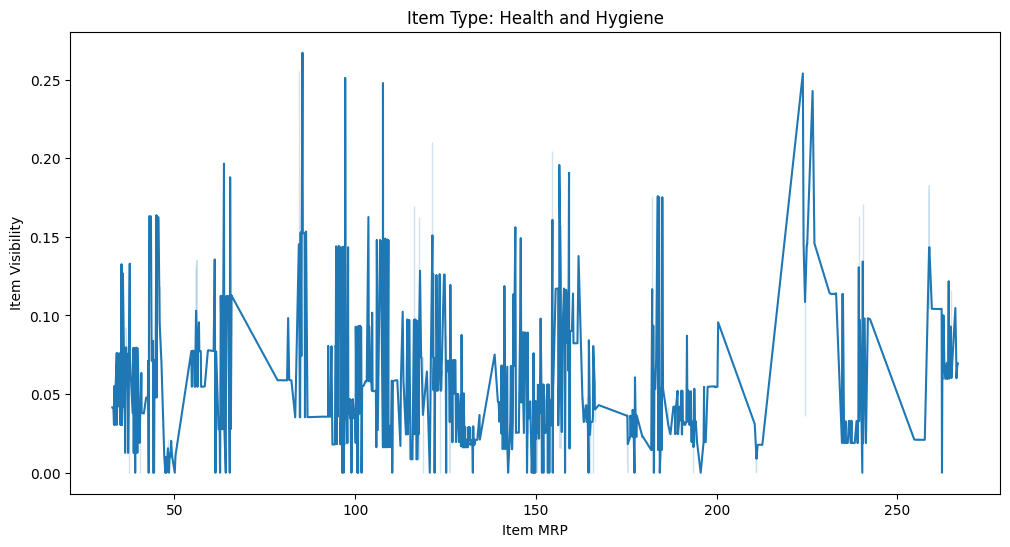

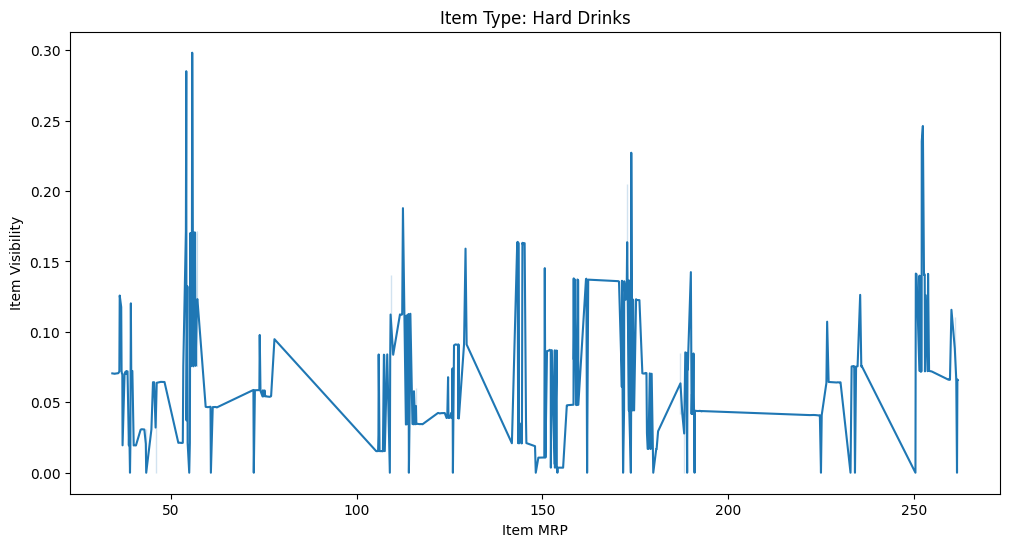

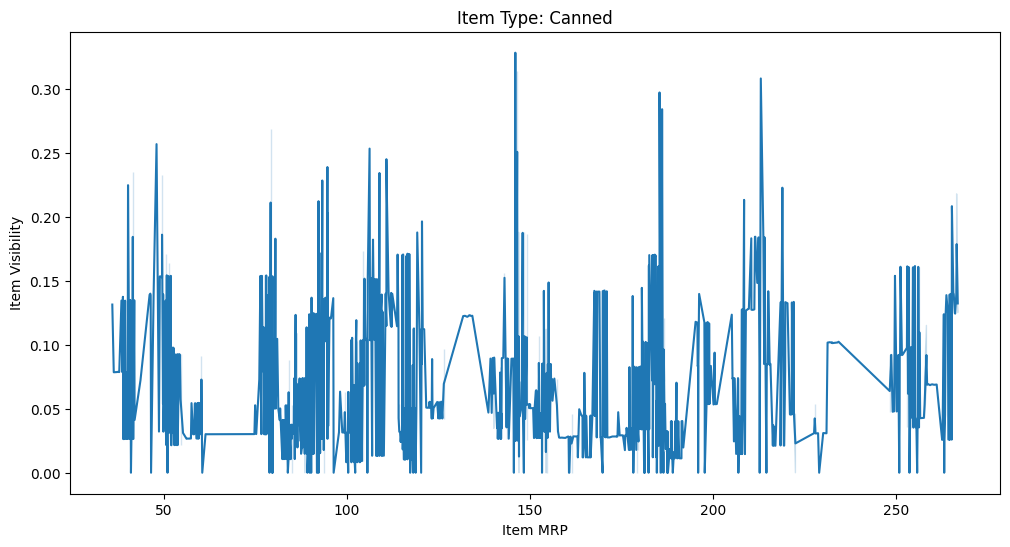

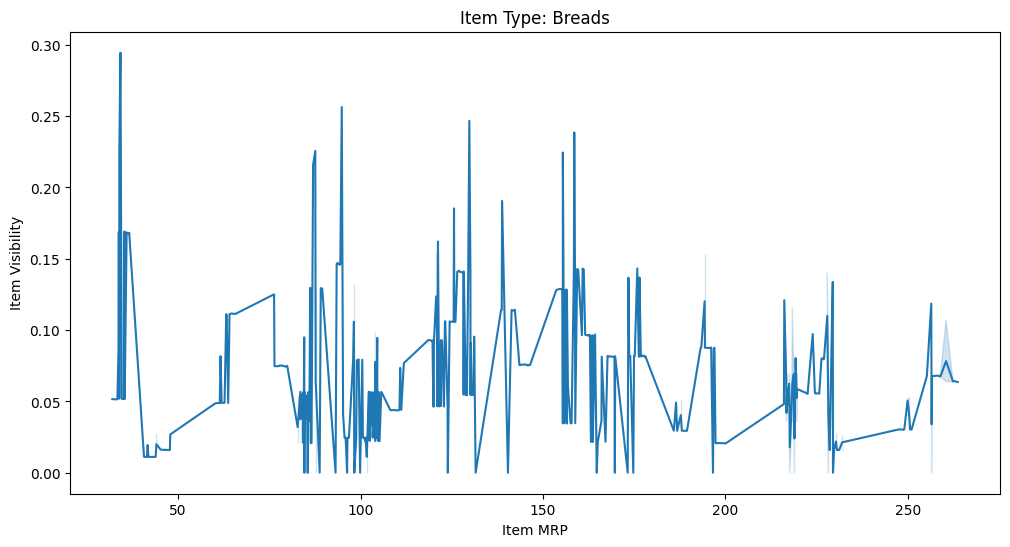

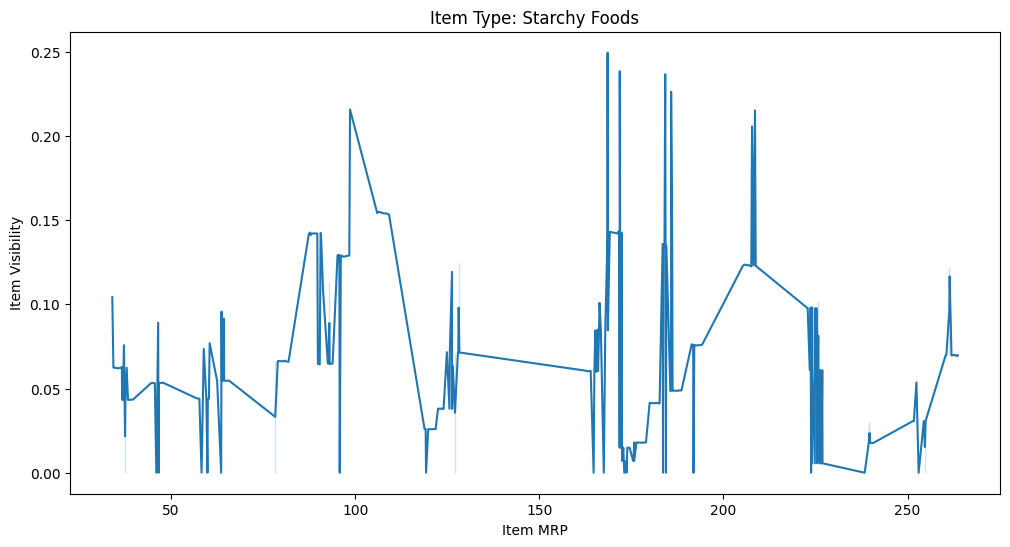

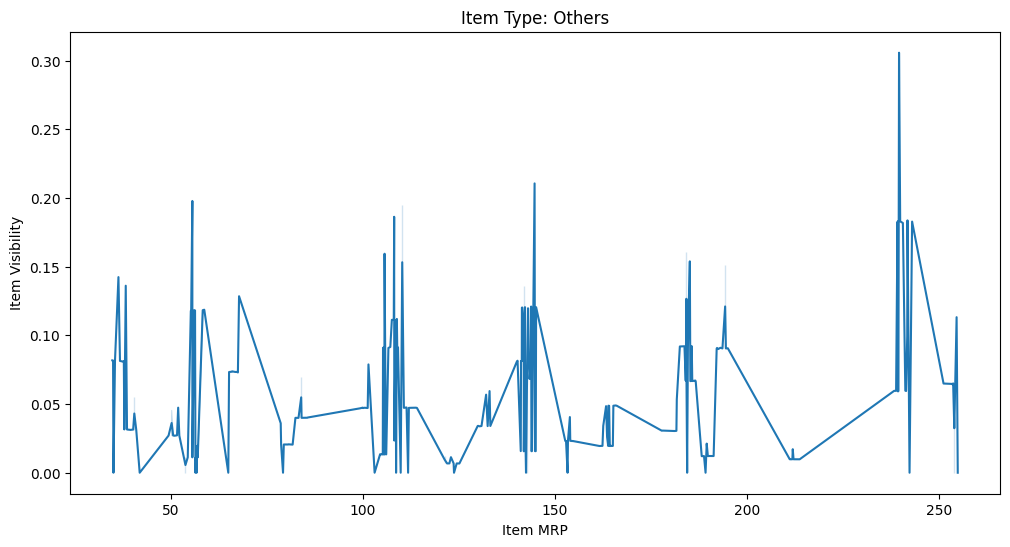

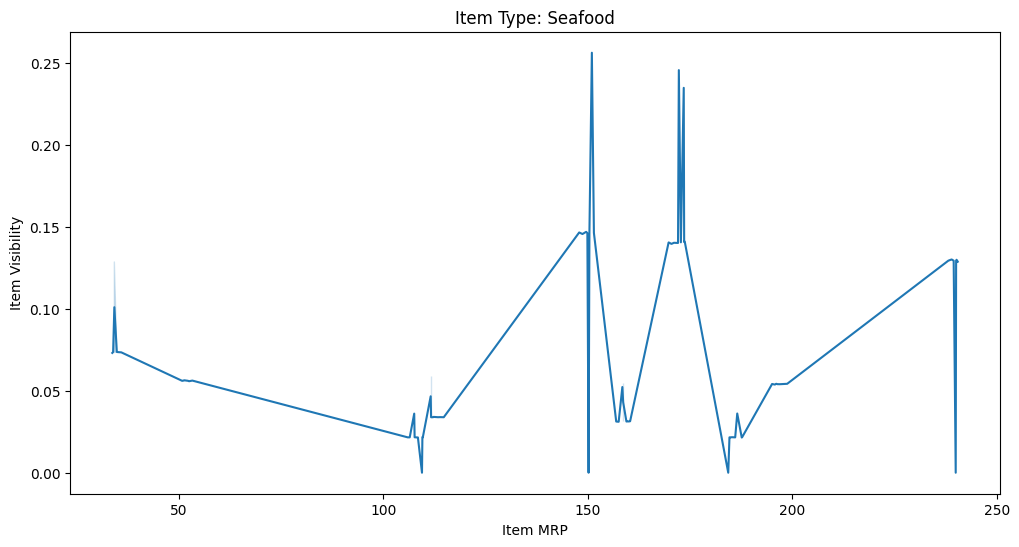

In [15]:
item_types = data["Item_Type"].unique()

for i, item_type in enumerate(item_types):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="Item_MRP", y="Item_Visibility", data=data[data["Item_Type"] == item_type])
    plt.xlabel("Item MRP")
    plt.ylabel("Item Visibility")
    plt.title(f"Item Type: {item_type}")
    plt.show()

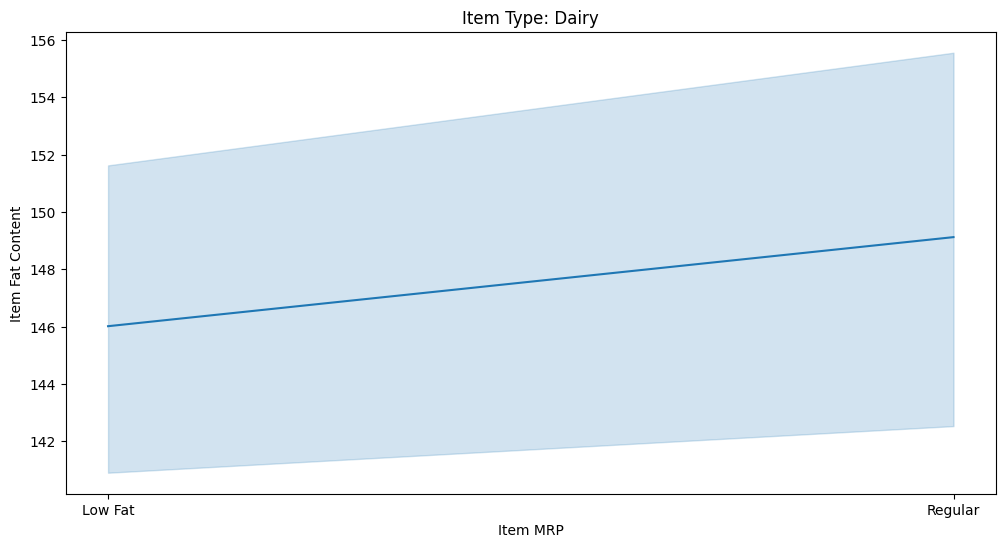

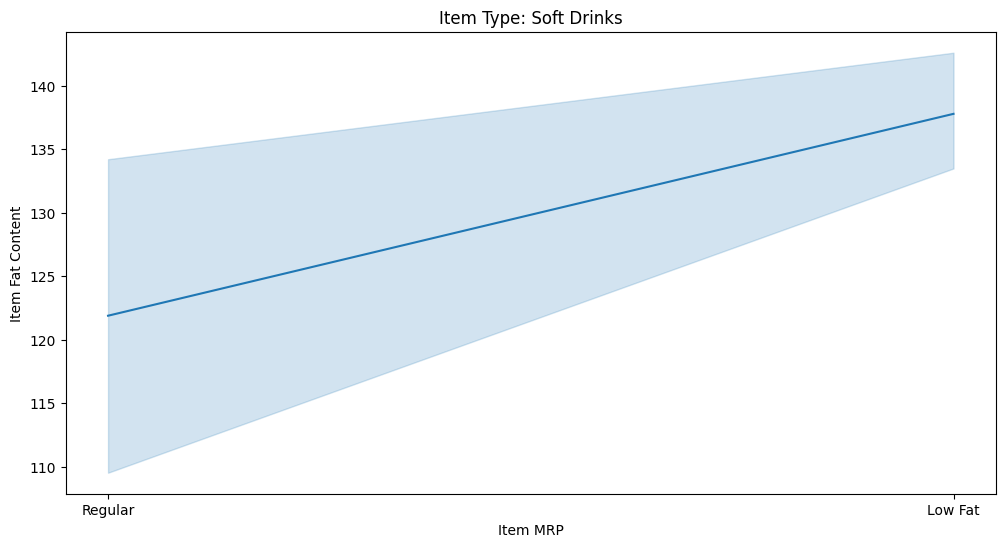

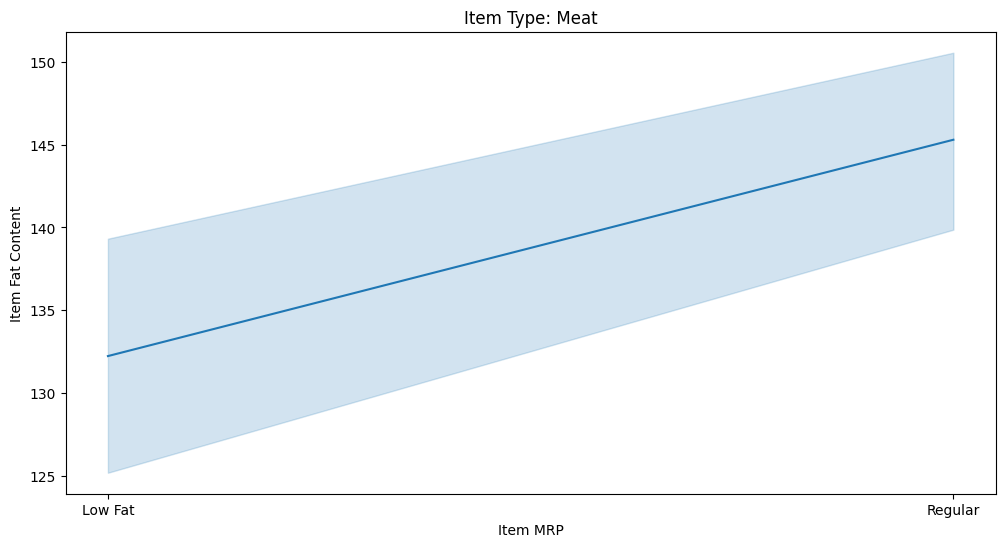

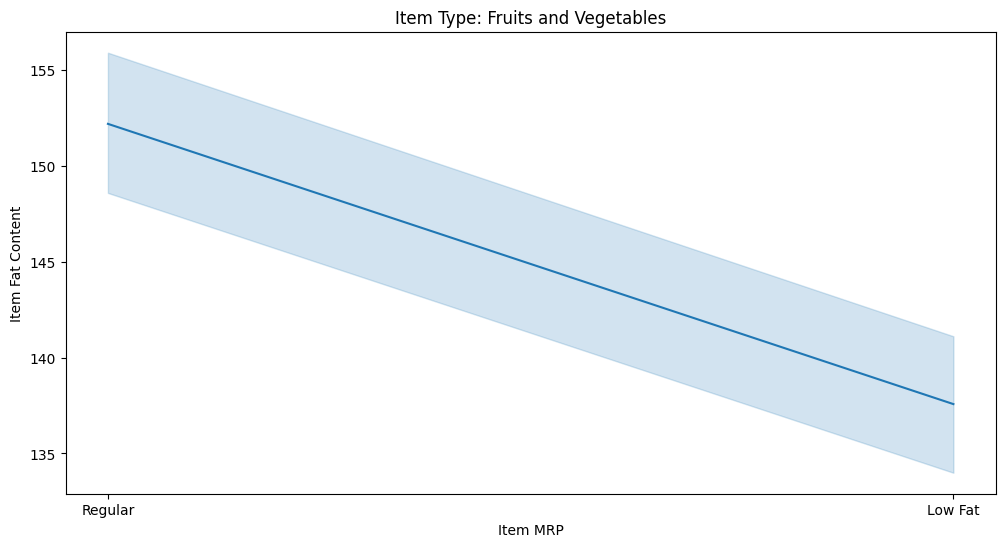

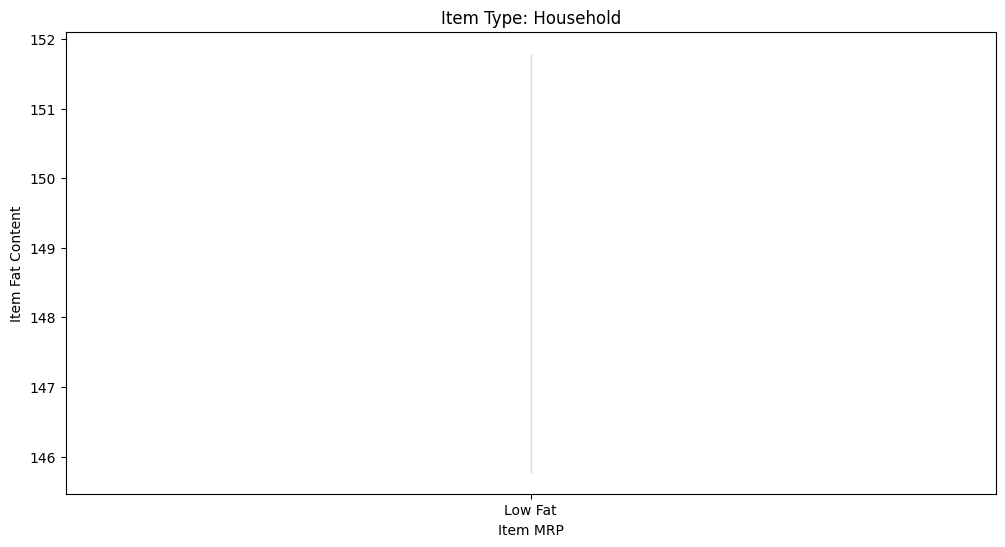

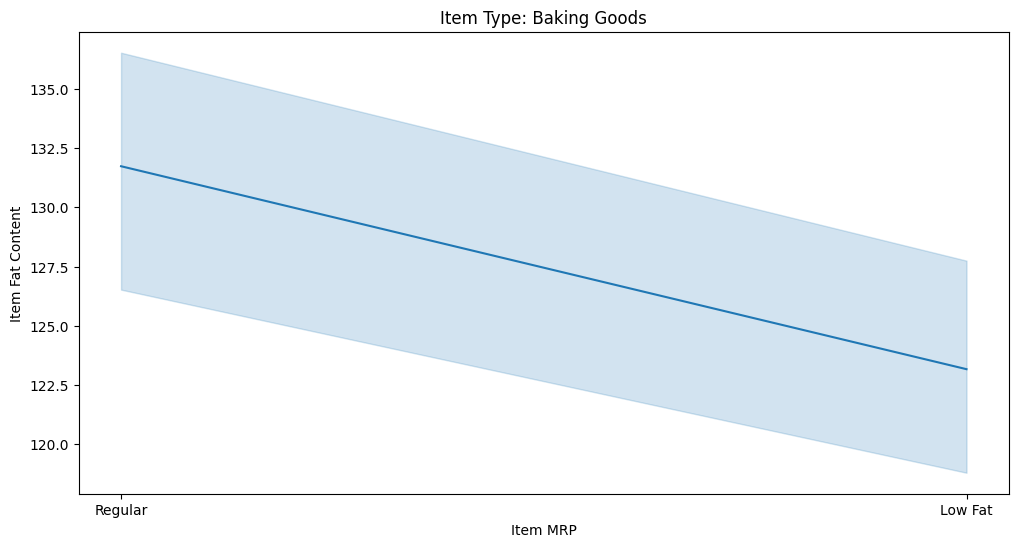

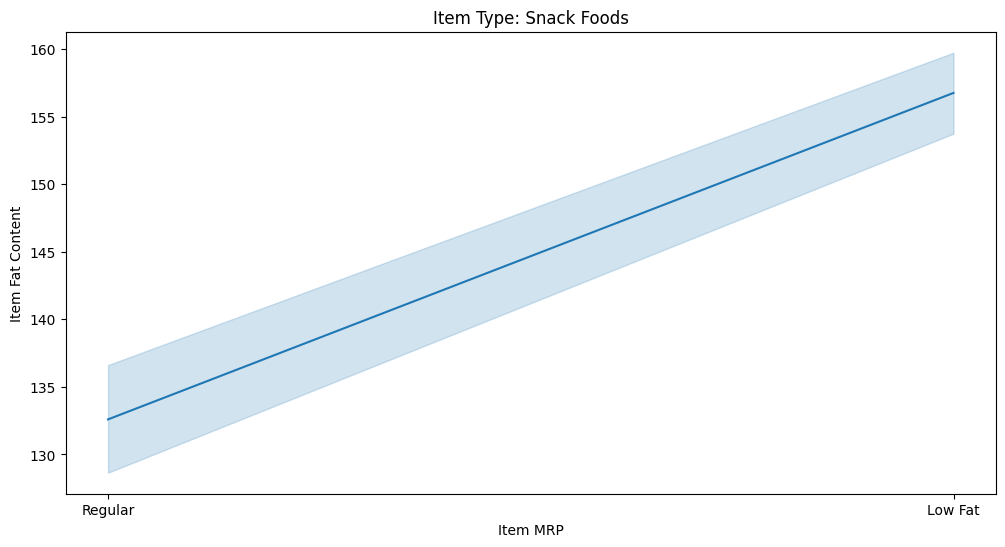

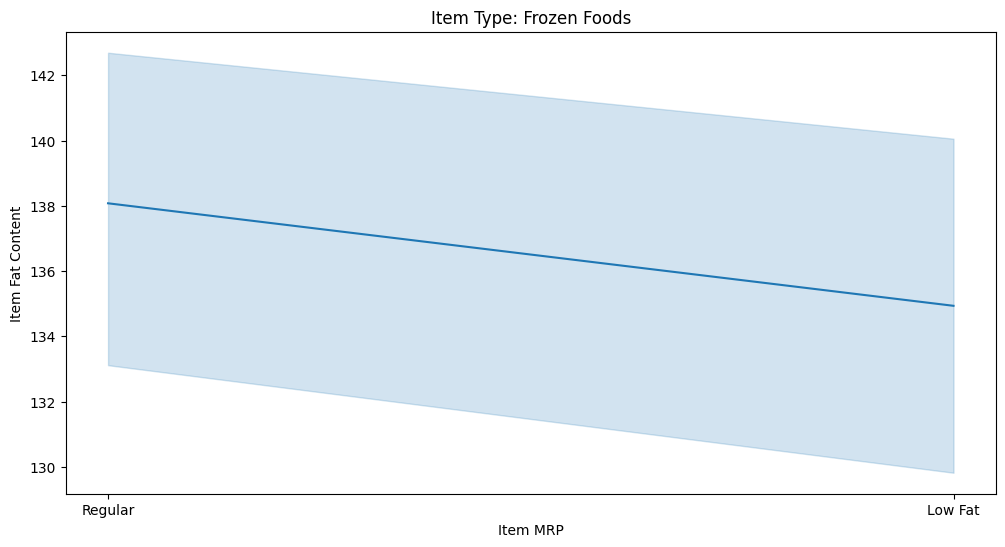

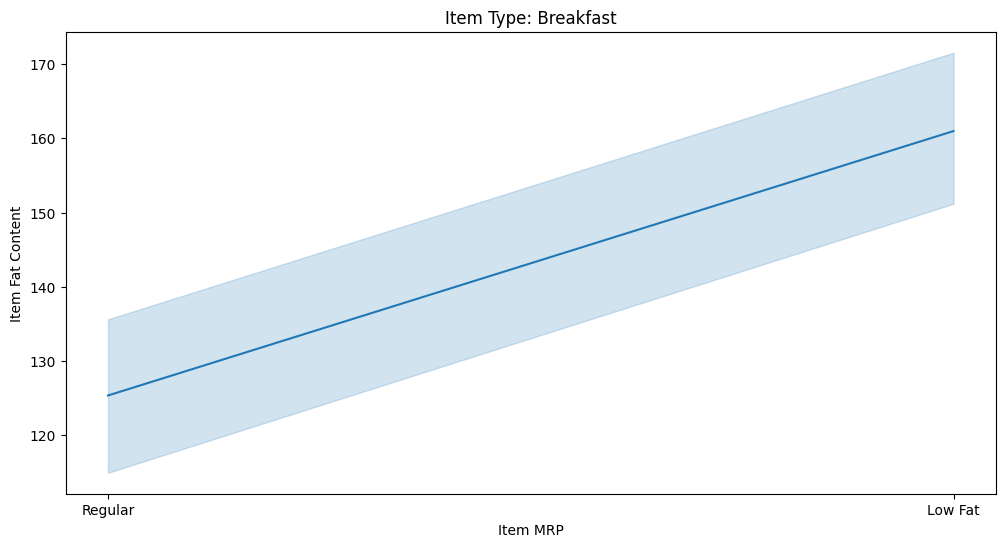

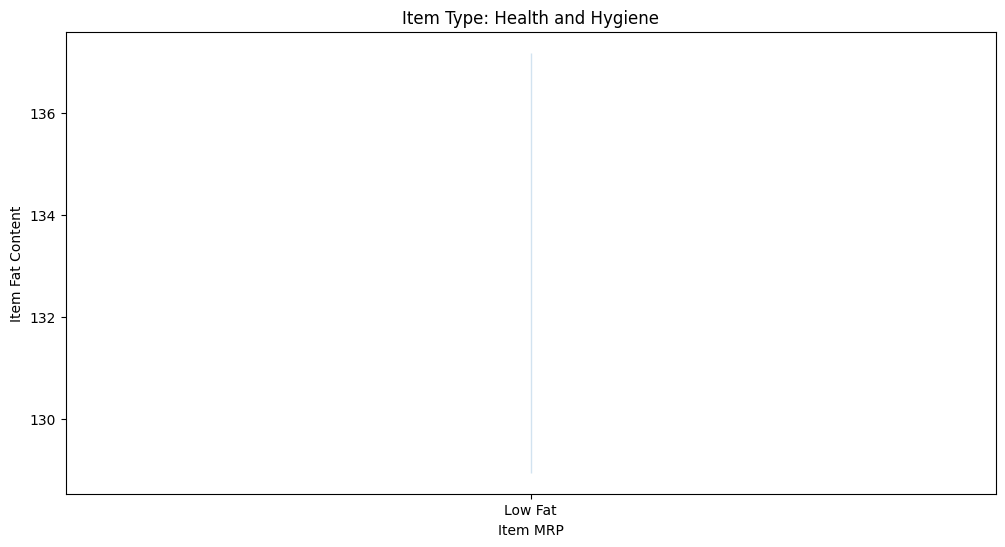

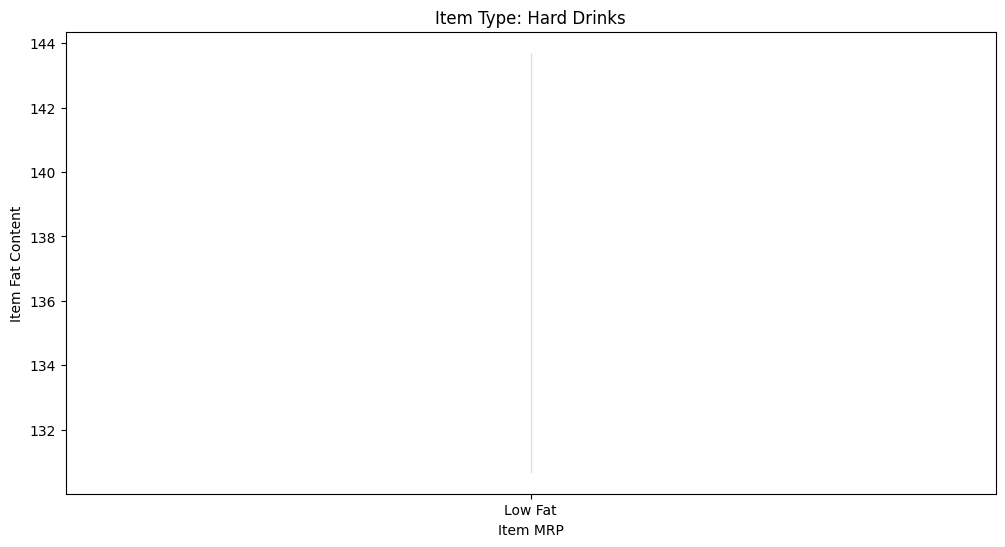

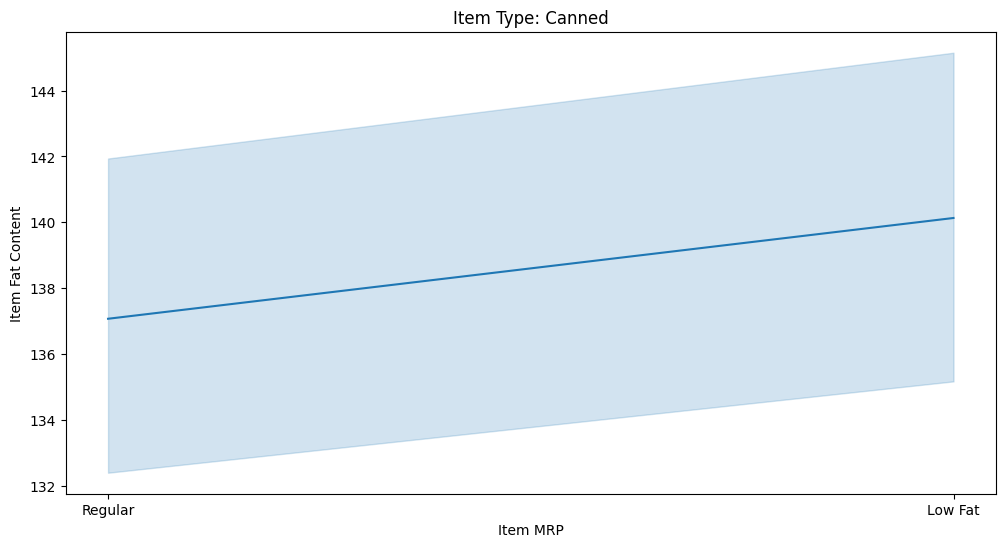

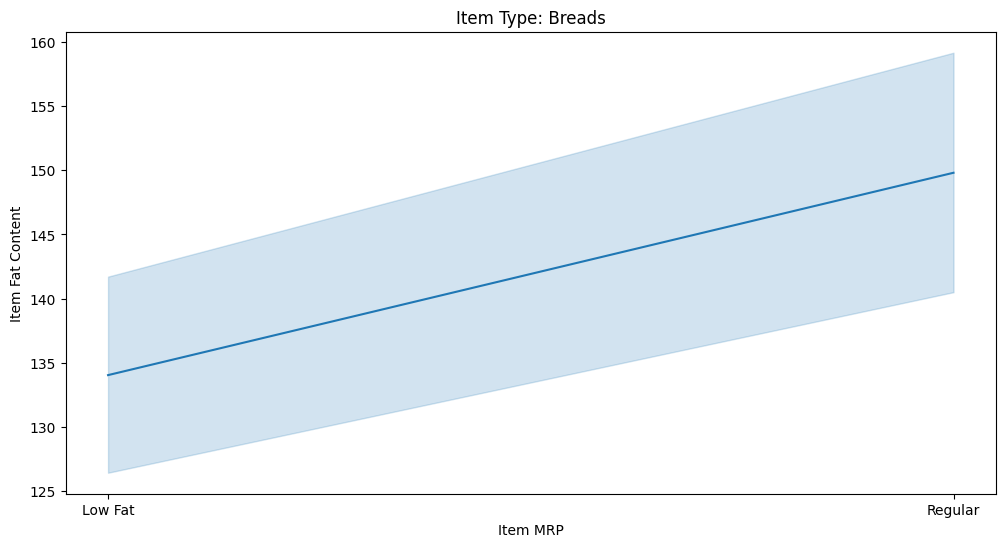

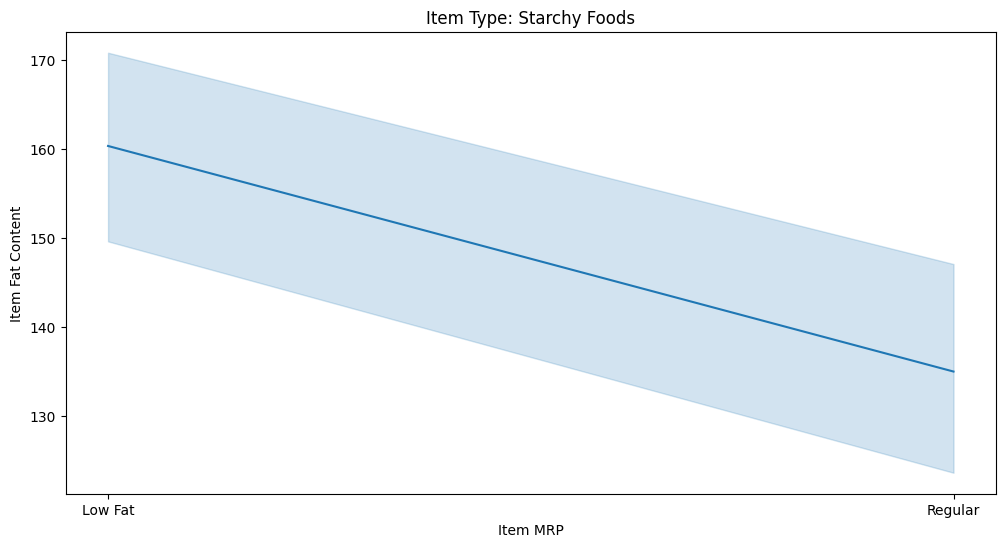

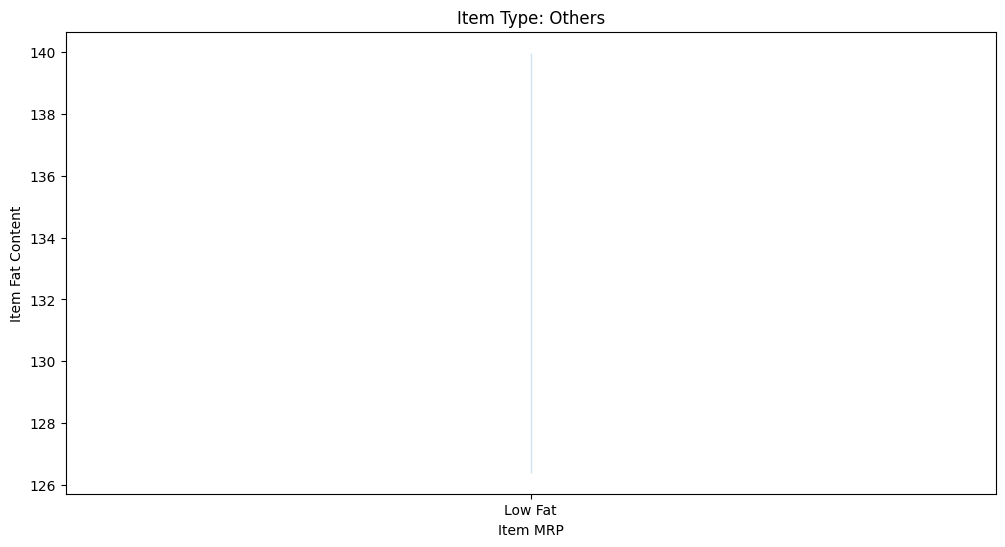

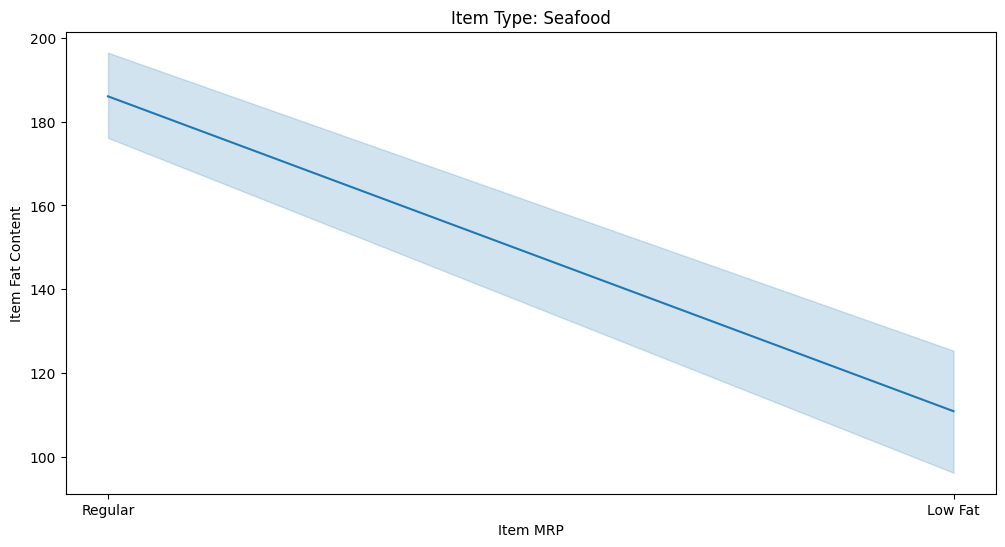

In [16]:
item_types = data["Item_Type"].unique()

for i, item_type in enumerate(item_types):
    plt.figure(figsize=(12, 6))
    sns.lineplot(y="Item_MRP", x="Item_Fat_Content", data=data[data["Item_Type"] == item_type])
    plt.xlabel("Item MRP")
    plt.ylabel("Item Fat Content")
    plt.title(f"Item Type: {item_type}")
    plt.show()